In [7]:
import pandas as pd
import numpy as np

# ✅ Load datasets
items = pd.read_csv("Items.csv")
sales = pd.read_csv("Sales.csv")
promotions = pd.read_csv("Promotion.csv")
supermarkets = pd.read_csv("Supermarkets.csv")

# ✅ Standardizing column names
items.rename(columns={'descrption': 'description'}, inplace=True)
promotions.rename(columns={'supermarkets': 'supermarket'}, inplace=True)
supermarkets.rename(columns={'supermarket_No': 'supermarket', 'postal-code': 'postal_code'}, inplace=True)

# ✅ Merge datasets correctly
merged_df = sales.merge(promotions, on=['code', 'supermarket'], how='left')
merged_df = merged_df.merge(items, on='code', how='left')
merged_df = merged_df.merge(supermarkets, on='supermarket', how='left')

# ✅ Drop redundant columns & rename
merged_df.drop(columns=['province_y', 'week_y'], inplace=True)
merged_df.rename(columns={'province_x': 'province', 'week_x': 'week'}, inplace=True)

# ✅ Remove duplicates
merged_df.drop_duplicates(subset=['code', 'supermarket', 'week', 'customerId', 'day'], inplace=True)

# ✅ Handle missing values
cols_to_fill = ['feature', 'display', 'description', 'type', 'brand', 'week', 'postal_code']
fill_values = ["NO PROMOTION", "NO PROMOTION", "UNSPECIFIED", "UNKNOWN", "GENERIC BRAND", 0, 0]
merged_df[cols_to_fill] = merged_df[cols_to_fill].fillna(dict(zip(cols_to_fill, fill_values)))

# ✅ Standardizing Text Columns
text_cols = ['feature', 'display', 'description', 'type', 'brand']
for col in text_cols:
    merged_df[col] = merged_df[col].astype(str).str.upper().str.strip()

# ✅ Ensure numeric columns are correct
merged_df['amount'] = merged_df['amount'].astype(float)
merged_df['units'] = merged_df['units'].astype(int)

print(f"✅ Data Loaded & Cleaned: {merged_df.shape}")


✅ Data Loaded & Cleaned: (1047675, 18)


In [8]:
from sklearn.preprocessing import OneHotEncoder

# ✅ Remove negative or NaN values in `amount`
merged_df = merged_df[merged_df["amount"] > 0]  # Keep only positive sales
merged_df = merged_df.dropna(subset=["amount"])  # Remove NaN values

# ✅ Apply log transformation safely
y_transformed = np.log1p(merged_df["amount"])  # log(1 + y) to prevent log(0)

# ✅ Select important categorical columns
categorical_cols = ["type", "brand"]

# ✅ Apply One-Hot Encoding
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_features = encoder.fit_transform(merged_df[categorical_cols])
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# ✅ Convert encoded features into DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=merged_df.index)

# ✅ Merge selected numeric + encoded features
X = pd.concat([merged_df[["units", "week", "supermarket"]], encoded_df], axis=1)

# ✅ Verify available feature columns
print(f"✅ Available Features: {X.columns.tolist()}")
print(f"✅ Cleaned Data: X = {X.shape}, y = {y_transformed.shape}")


✅ Available Features: ['units', 'week', 'supermarket', 'type_TYPE 1', 'type_TYPE 2', 'type_TYPE 3', 'type_TYPE 4', 'brand_AL DENTE', 'brand_ALAGA', 'brand_ALESSI', 'brand_AMORE', 'brand_ANNARINO', 'brand_ANNIE CHNS', 'brand_ARLOW', 'brand_AUNT JEMIMA', 'brand_BARILLA', 'brand_BELLINO', 'brand_BERTOLLI', 'brand_BISQUICK', 'brand_BOVES', 'brand_BRIER RABBIT', "brand_BROTHER'S", "brand_BRUCE'S", 'brand_BUITONI', 'brand_CANDONI', 'brand_CARA NONA', "brand_CARY'S", 'brand_CENTO', 'brand_CHEF PIZZA', 'brand_CLASSICO', 'brand_CLASSIQUE', 'brand_COLAVITA', 'brand_COZY COTTAGE', 'brand_CREAMETTE', 'brand_CUCINA', 'brand_DARIELLE', "brand_DAVE'S", 'brand_DAVINCI', 'brand_DECECCO', 'brand_DEFINO', 'brand_DELL ALPE', 'brand_DELL AMORE', 'brand_EDDIE', 'brand_EDEN', "brand_ELENA'S", "brand_EMERIL'S", 'brand_ENRICO', 'brand_FARM STYLE', 'brand_FASTSHAKE', 'brand_FERRARA', 'brand_FIFTY 50', 'brand_GOLDEN EAGLE', 'brand_GOOCH', 'brand_GRANDMA MOLASES', 'brand_HEALTHY HARVEST', 'brand_HODGSON MILLS', "

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ✅ Reduce training size (50% train, 50% test) for stability
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.5, random_state=42)

# ✅ Standardizing numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data Prepared with Log-Transformed Sales & No Invalid Values")


✅ Data Prepared with Log-Transformed Sales & No Invalid Values


In [10]:
from sklearn.neural_network import MLPRegressor

# ✅ Define and train the Neural Network model with increased iterations
mlp_model = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=1000, random_state=42)

# ✅ Train the model
mlp_model.fit(X_train_scaled, y_train)

print("✅ Neural Network Model Retrained with Increased Iterations")


✅ Neural Network Model Retrained with Increased Iterations


In [11]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# ✅ Make predictions
y_pred = mlp_model.predict(X_test_scaled)

# ✅ Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# ✅ Print results
print(f"📊 Neural Network Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


📊 Neural Network Model Performance:
RMSE: 0.1664
R² Score: 0.7555


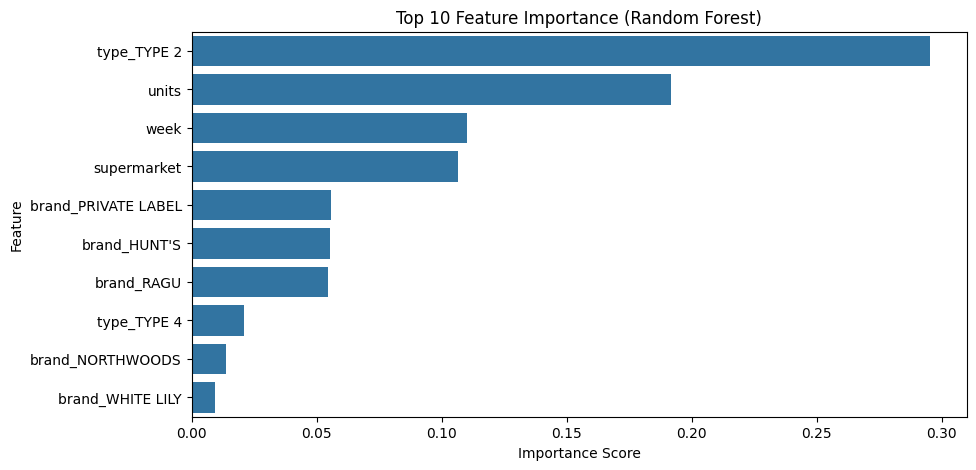

<ipython-input-12-063fd1b7a256>:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=merged_df, x='week', y='amount', ci=None)


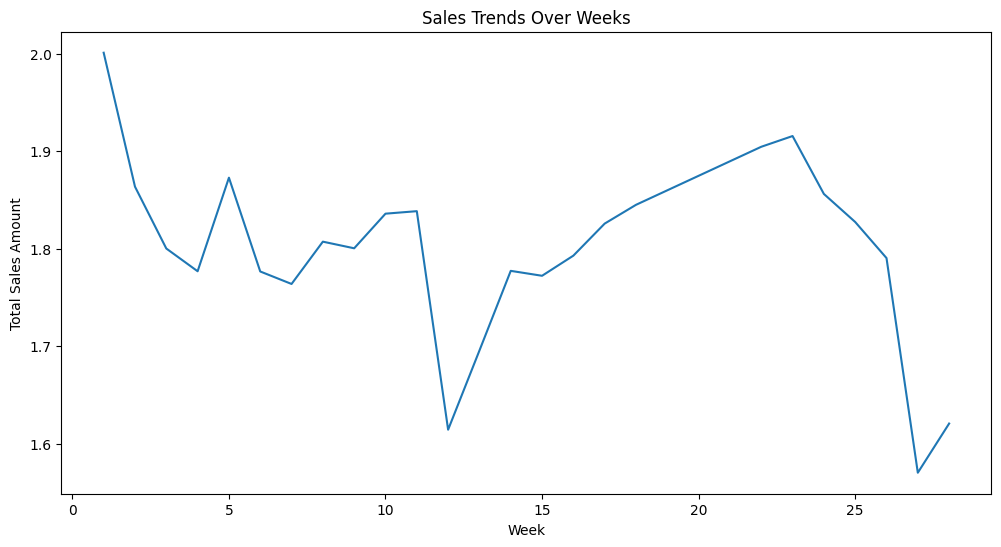

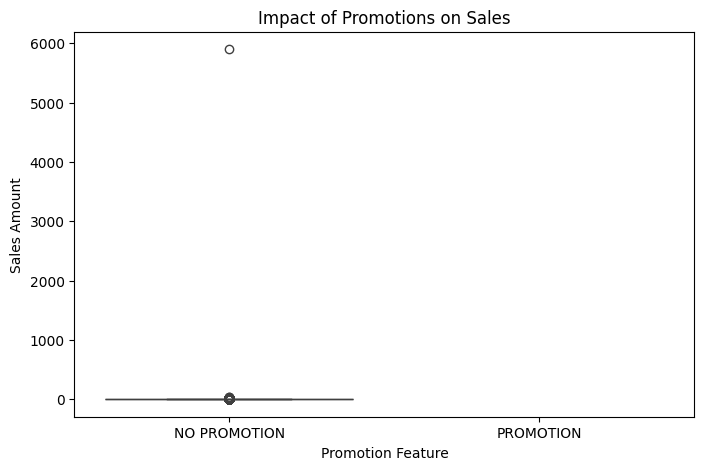

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Feature Importance Analysis (for Random Forest)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Get feature importance
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# ✅ Plot Feature Importance
plt.figure(figsize=(10, 5))
sns.barplot(data=feature_importances.head(10), x='Importance', y='Feature')
plt.title("Top 10 Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# ✅ Sales Trends Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='week', y='amount', ci=None)
plt.title("Sales Trends Over Weeks")
plt.xlabel("Week")
plt.ylabel("Total Sales Amount")
plt.show()

# ✅ Impact of Promotions on Sales
plt.figure(figsize=(8, 5))
sns.boxplot(data=merged_df, x='feature', y='amount', order=["NO PROMOTION", "PROMOTION"])
plt.title("Impact of Promotions on Sales")
plt.xlabel("Promotion Feature")
plt.ylabel("Sales Amount")
plt.show()


With other Models:

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# ✅ Reduce complexity for faster training
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42, max_depth=10),  # Limit tree depth
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42),  # Reduce trees
    "Neural Network": MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=100, random_state=42)  # Reduce iterations
}

# ✅ Train models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)

print("✅ Models Retrained with Optimized Parameters")


✅ Models Retrained with Optimized Parameters


In [14]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# ✅ Evaluate models
results = []

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append([name, rmse, r2])

# ✅ Create results DataFrame
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R² Score"])

# ✅ Print updated performance
print("\n📊 Updated Model Performance with Optimized Training:")
print(results_df)



📊 Updated Model Performance with Optimized Training:
               Model      RMSE  R² Score
0  Linear Regression  0.204144  0.631858
1      Decision Tree  0.178550  0.718381
2      Random Forest  0.172063  0.738471
3     Neural Network  0.166357  0.755529


In [15]:
from google.colab import files

# Save the cleaned and merged dataset
merged_df.to_csv("cleaned_merged_data.csv", index=False)

# Download the file
files.download("cleaned_merged_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>